# Gagneur Course on PRS

> *Gist of the course*: get 2 PRS, CAD and a highly heritable protein, apply to 1KG, then associate. Repeat assoc with white samples only: higher assoc? population sensitivity of scores. Also, extract loadings from PC1 ັືand construct an "ethnicity score" and do validation

## Pre-everything: get the NGS data from 1kg
Various releases here, we take the 2504 high coverage as it has unrelated individuals. Axel is a lifesaver here because the server is really unstable:

```bash
cd /lustre/groups/itg/shared/referenceData/1kG
wget -O- http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/working/20190425_NYGC_GATK/ | grep vcf| sed 's/.*href..//;s/\".*//' | while read f; do axel -a -o 20190425_NYGC_GATK/$f http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/working/20190425_NYGC_GATK/$f;done
```

We also get the sheet that gives ethnicities from https://www.internationalgenome.org/data-portal/data-collection/30x-grch38.

These VCFs are GRCh38 which is good.

Question 1: Download the CAD PRS from https://www.pgscatalog.org/score/PGS000337/.

Task 1: Lift over.

### Lifting over the coordinates

In [26]:
!pip3 install liftover

Defaulting to user installation because normal site-packages is not writeable
  Using cached liftover-1.1.11.tar.gz (83 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for liftover: filename=liftover-1.1.11-cp310-cp310-linux_x86_64.whl size=743465 sha256=5d8f0c30287e7e53ac677e17f89bb98a18553e6fb0b397013a45023b74025952
  Stored in directory: /home/itg/arthur.gilly/.cache/pip/wheels/49/ed/6a/99d90b63971d207077f21d4890640278f4cb94c00b786d42f6
Successfully built liftover
You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.


In [27]:
from liftover import get_lifter
lo = get_lifter('hg19', 'hg38')

In [28]:
lo.convert_coordinate(1, 1171417)[0]

('chr1', 1236037, '+')

In [80]:
import pandas as pd
cadscore=pd.read_csv("/lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PGS000337.txt.gz",
                    sep="\t", comment="#")

In [81]:
cadscore

,chr_name,chr_position,effect_allele,effect_weight,variant_description
0,1,959231,A,0.011321,1:959231:G:A
1,1,1119858,T,-0.016588,1:1119858:C:T
2,1,1122024,C,0.013543,1:1122024:T:C
3,1,1154858,T,-0.024307,1:1154858:C:T
4,1,1171417,T,-0.012684,1:1171417:C:T
...,...,...,...,...,...
75023,22,51091914,T,0.020546,22:51091914:C:T
75024,22,51095286,T,0.022332,22:51095286:C:T
75025,22,51104170,G,0.011036,22:51104170:A:G
75026,22,51115863,A,0.021235,22:51115863:G:A


In [82]:
cadscore['chr_name'] = 'chr' + cadscore['chr_name'].astype(str)
cadscore['pos.b38']=cadscore.apply(lambda x:lo.convert_coordinate(x.chr_name, x.chr_position), axis=1)

In [83]:
# remove those positions that map to several in the new build
ix=cadscore['pos.b38'].str.len()==1
cadscore=cadscore.loc[ix]

cadscore.loc[:, 'chr_b38']=cadscore['pos.b38'].map(lambda x: x[0][0])
cadscore.loc[:, 'ps_b38']=cadscore['pos.b38'].map(lambda x: x[0][1])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [84]:
cadscore.drop(columns="pos.b38", inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [85]:
cadscore

,chr_name,chr_position,effect_allele,effect_weight,variant_description,chr_b38,ps_b38
0,chr1,959231,A,0.011321,1:959231:G:A,chr1,1023851
1,chr1,1119858,T,-0.016588,1:1119858:C:T,chr1,1184478
2,chr1,1122024,C,0.013543,1:1122024:T:C,chr1,1186644
3,chr1,1154858,T,-0.024307,1:1154858:C:T,chr1,1219478
4,chr1,1171417,T,-0.012684,1:1171417:C:T,chr1,1236037
...,...,...,...,...,...,...,...
75023,chr22,51091914,T,0.020546,22:51091914:C:T,chr22,50653486
75024,chr22,51095286,T,0.022332,22:51095286:C:T,chr22,50656858
75025,chr22,51104170,G,0.011036,22:51104170:A:G,chr22,50665742
75026,chr22,51115863,A,0.021235,22:51115863:G:A,chr22,50677435


In [86]:
cadscore=cadscore[cadscore['chr_b38'].str.fullmatch("chr[\d]+")]

In [87]:
cadscore

,chr_name,chr_position,effect_allele,effect_weight,variant_description,chr_b38,ps_b38
0,chr1,959231,A,0.011321,1:959231:G:A,chr1,1023851
1,chr1,1119858,T,-0.016588,1:1119858:C:T,chr1,1184478
2,chr1,1122024,C,0.013543,1:1122024:T:C,chr1,1186644
3,chr1,1154858,T,-0.024307,1:1154858:C:T,chr1,1219478
4,chr1,1171417,T,-0.012684,1:1171417:C:T,chr1,1236037
...,...,...,...,...,...,...,...
75023,chr22,51091914,T,0.020546,22:51091914:C:T,chr22,50653486
75024,chr22,51095286,T,0.022332,22:51095286:C:T,chr22,50656858
75025,chr22,51104170,G,0.011036,22:51104170:A:G,chr22,50665742
75026,chr22,51115863,A,0.021235,22:51115863:G:A,chr22,50677435


In [88]:
cadscore.to_csv("/lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PGS000337.b38.txt", sep="\t")

## Protein score

After much searching we realise we do NOT have the score! For the simple reason that we used PRSice2 and that this does a clever merge and score at the same time.

We can do something a bit meh which is to start from the clumped 1e-4 results and filter out those that are <the best threshold. So:

```bash
zcat /storage/sanger/projects/helic/t144_helic_15x/analysis/HA/OLINK/single_point/META/META.MEP1B/MANOLIS.META.MEP1B.assoc.txt.gz| awk '$NF<1.07e-9 && $7>0.05'|fgrep -f <(cut -f1 META.MEP1B.scorevar.clumped.leadvars.beta) | cut -f1,3,5,6,8
```

Which gives us:
```
18      32038169        T       C       -2.891709e-01
18      32067215        C       T       4.230704e-01
18      32208550        G       C       -6.470447e-01
18      32224458        T       C       -6.871607e-01
18      32224900        A       T       -1.070113e+00
18      32317264        C       G       -5.560340e-01
18      32337385        C       T       3.294772e-01
```

We could do an independence test here:




In [89]:
from io import StringIO
mep1b_score=pd.read_table(StringIO("""18      32038169        T       C       -2.891709e-01
18      32067215        C       T       4.230704e-01
18      32208550        G       C       -6.470447e-01
18      32224458        T       C       -6.871607e-01
18      32224900        A       T       -1.070113e+00
18      32317264        C       G       -5.560340e-01
18      32337385        C       T       3.294772e-01
"""), header=None, delim_whitespace=True)

In [90]:
mep1b_score.columns=["chr", "pos", "A1", "A2", "effect"]

In [91]:
mep1b_score

,chr,pos,A1,A2,effect
0,18,32038169,T,C,-0.289171
1,18,32067215,C,T,0.423070
2,18,32208550,G,C,-0.647045
3,18,32224458,T,C,-0.687161
4,18,32224900,A,T,-1.070113
5,18,32317264,C,G,-0.556034
6,18,32337385,C,T,0.329477


## List of positions for extraction

In [92]:
cadscore

,chr_name,chr_position,effect_allele,effect_weight,variant_description,chr_b38,ps_b38
0,chr1,959231,A,0.011321,1:959231:G:A,chr1,1023851
1,chr1,1119858,T,-0.016588,1:1119858:C:T,chr1,1184478
2,chr1,1122024,C,0.013543,1:1122024:T:C,chr1,1186644
3,chr1,1154858,T,-0.024307,1:1154858:C:T,chr1,1219478
4,chr1,1171417,T,-0.012684,1:1171417:C:T,chr1,1236037
...,...,...,...,...,...,...,...
75023,chr22,51091914,T,0.020546,22:51091914:C:T,chr22,50653486
75024,chr22,51095286,T,0.022332,22:51095286:C:T,chr22,50656858
75025,chr22,51104170,G,0.011036,22:51104170:A:G,chr22,50665742
75026,chr22,51115863,A,0.021235,22:51115863:G:A,chr22,50677435


In [99]:
cponly=pd.DataFrame({'chr' : cadscore.chr_b38.str.replace('chr', '').astype(int), 'pos' : cadscore.ps_b38})

In [115]:
cponly=cponly.append(mep1b_score[['chr', 'pos']])

In [116]:
cponly.to_csv("/lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/to.extract", sep="\t", header=None)

## Extracting these from 1kg and hoping it's not too big

```bash
cut -f2,3 to.extract | sed 's/^/chr/' > to.extract.chrpos
for i in {1..20} 22; do bcftools view -R to.extract.chrpos -Oz -o chr$i.vcf.gz /lustre/groups/itg/shared/referenceData/1kG/20190425_NYGC_GATK/CCDG_13607_B01_GRM_WGS_2019-02-19_chr$i.recalibrated_variants.vcf.gz & done
bcftools concat -Oz -o autosomal.forPRS.vcf.gz $(echo chr{1..22}.vcf.gz)
plink --set-missing-var-ids @:# --vcf autosomal.forPRS.vcf.gz --make-bed --out autosomal.forPRS
plink --vcf autosomal.forPRS.vcf.gz --set-missing-var-ids @:# --recode A --out autosomal.forPRS.mx
```

The VCF is big but the plink not really. Even the raw is ok compressed 45Mb.

We need a slightly different file for scoring, chr:pos allele weight. Easypeasy.

In [108]:
scfile=pd.DataFrame({'id' : cadscore.chr_b38+":"+cadscore.ps_b38.astype(str), 'ea' : cadscore.effect_allele, 'wt' : cadscore.effect_weight})

In [109]:
scfile

,id,ea,wt
0,chr1:1023851,A,0.011321
1,chr1:1184478,T,-0.016588
2,chr1:1186644,C,0.013543
3,chr1:1219478,T,-0.024307
4,chr1:1236037,T,-0.012684
...,...,...,...
75023,chr22:50653486,T,0.020546
75024,chr22:50656858,T,0.022332
75025,chr22:50665742,G,0.011036
75026,chr22:50677435,A,0.021235


In [111]:
mep=pd.DataFrame({'id' : 'chr' + mep1b_score.chr.astype(str)+ ':' +mep1b_score.pos.astype(str), 'ea' : mep1b_score.A1, 'wt' : mep1b_score.effect})

In [112]:
scfile.to_csv("/lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/cad.scorefile", sep="\t", header=None, index=False)
mep.to_csv("/lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/mep1b.scorefile", sep="\t", header=None, index=False)

## Applying scores

### Plink style

```bash
plink --score cad.scorefile center --bfile autosomal.forPRS --out cadscore
plink --score mep1b.scorefile center --bfile autosomal.forPRS --out mepscore
```

In [118]:
csc=pd.read_table("/lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/cadscore.profile",
                    delim_whitespace=True)

In [120]:
!pip install seaborn

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable


In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SCORE', ylabel='Density'>

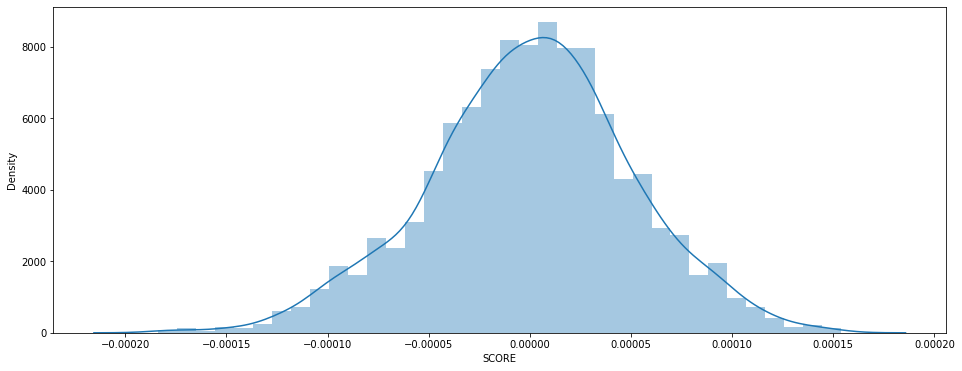

In [127]:
plt.figure(figsize=(16, 6))
sns.distplot(csc.SCORE)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SCORE', ylabel='Density'>

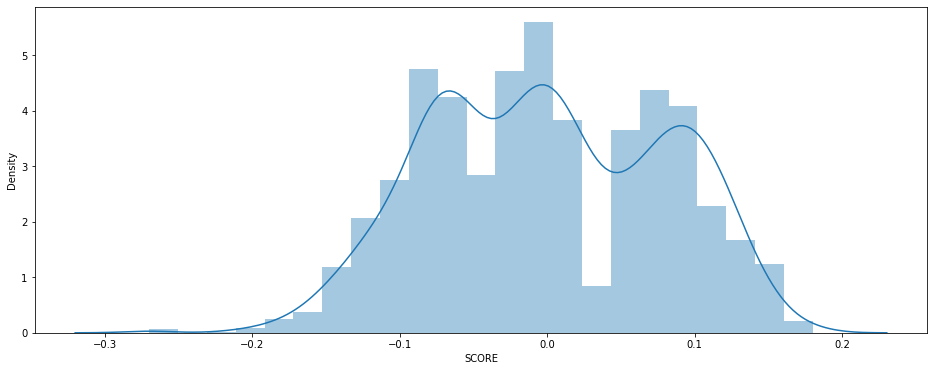

In [128]:
msc=pd.read_table("/lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/mepscore.profile",
                    delim_whitespace=True)
plt.figure(figsize=(16, 6))
sns.distplot(msc.SCORE)

### Applying the score manually

In [179]:
genos=pd.read_table("/lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/autosomal.forPRS.mx.traw",
                   delim_whitespace=True)

In [180]:
samplecols=genos.columns[6:]

In [181]:
mepg=genos[genos.SNP.isin(mep.id)]

In [182]:
mepg.reset_index(inplace=True)
mepg

,index,CHR,SNP,(C)M,POS,COUNTED,ALT,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,...,NA21128_NA21128,NA21129_NA21129,NA21130_NA21130,NA21133_NA21133,NA21135_NA21135,NA21137_NA21137,NA21141_NA21141,NA21142_NA21142,NA21143_NA21143,NA21144_NA21144
0,68063,18,chr18:32038169,0,32038169,T,C,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0
1,68064,18,chr18:32067215,0,32067215,C,T,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,68071,18,chr18:32208550,0,32208550,G,C,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
3,68074,18,chr18:32224458,0,32224458,T,C,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,68075,18,chr18:32224900,0,32224900,A,T,2.0,2.0,1.0,...,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0
5,68078,18,chr18:32317264,0,32317264,C,G,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,68079,18,chr18:32337385,0,32337385,C,T,1.0,2.0,0.0,...,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0


In [183]:
mepscoreg=mepg[samplecols].mul(mep.wt, axis='index')

In [184]:
mepscoreg

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00100_HG00100,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00106_HG00106,HG00107_HG00107,...,NA21128_NA21128,NA21129_NA21129,NA21130_NA21130,NA21133_NA21133,NA21135_NA21135,NA21137_NA21137,NA21141_NA21141,NA21142_NA21142,NA21143_NA21143,NA21144_NA21144
0,-0.000000,-0.289171,-0.289171,-0.578342,-0.289171,-0.000000,-0.289171,-0.289171,-0.289171,-0.578342,...,-0.000000,-0.289171,-0.289171,-0.289171,-0.289171,-0.578342,-0.000000,-0.289171,-0.000000,-0.289171
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.000000,-0.647045,-0.647045,-0.000000,-0.000000,-0.000000,-0.647045,-0.000000,-0.000000,-0.647045,...,-0.647045,-0.647045,-0.000000,-0.000000,-0.000000,-0.647045,-0.000000,-0.000000,-1.294089,-0.647045
3,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.687161
4,-2.140226,-2.140226,-1.070113,-0.000000,-2.140226,-1.070113,-2.140226,-0.000000,-2.140226,-1.070113,...,-1.070113,-1.070113,-1.070113,-2.140226,-1.070113,-1.070113,-0.000000,-0.000000,-2.140226,-2.140226
5,-0.000000,-0.000000,-0.000000,-0.000000,-0.556034,-0.000000,-0.000000,-0.000000,-0.556034,-0.000000,...,-0.000000,-0.556034,-0.556034,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
6,0.329477,0.658954,0.000000,0.329477,0.329477,0.329477,0.329477,0.329477,0.000000,0.329477,...,0.329477,0.329477,0.329477,0.000000,0.658954,0.658954,0.329477,0.329477,0.658954,0.329477


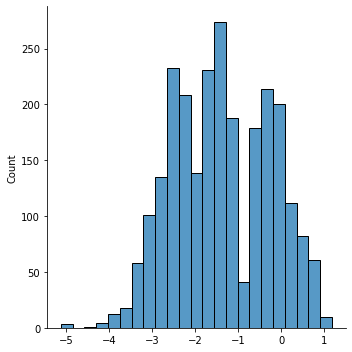

In [187]:
sns.displot(mepscoreg.sum())

In [188]:
cadg=genos[genos.SNP.isin(scfile.id)]

In [189]:
cadg

,CHR,SNP,(C)M,POS,COUNTED,ALT,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00100_HG00100,...,NA21128_NA21128,NA21129_NA21129,NA21130_NA21130,NA21133_NA21133,NA21135_NA21135,NA21137_NA21137,NA21141_NA21141,NA21142_NA21142,NA21143_NA21143,NA21144_NA21144
0,1,chr1:1023851,0,1023851,A,G,0.0,1.0,2.0,1.0,...,1.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0
1,1,chr1:1184478,0,1184478,T,C,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
2,1,chr1:1186644,0,1186644,C,T,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,1,chr1:1219478,0,1219478,T,C,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,chr1:1236037,0,1236037,C,T,1.0,1.0,2.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75619,22,chr22:50653486,0,50653486,T,C,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
75620,22,chr22:50656858,0,50656858,T,C,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
75621,22,chr22:50665742,0,50665742,A,G,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0
75622,22,chr22:50677435,0,50677435,A,G,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [192]:
len(scfile.ea)

75022

In [193]:
len(cadg.COUNTED)

74935

In [195]:
cadg=cadg.merge(scfile, left_on='SNP', right_on="id")

In [205]:
cadg.concordant=cadg[cadg.COUNTED==cadg.ea]
cadg.discordant=cadg[cadg.ALT==cadg.ea]

In [209]:
cadg.discordant=cadg.discordant[samplecols].mul(cadg.discordant['wt']*-1, axis='index')

In [210]:
cadg.discordant

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00100_HG00100,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00106_HG00106,HG00107_HG00107,...,NA21128_NA21128,NA21129_NA21129,NA21130_NA21130,NA21133_NA21133,NA21135_NA21135,NA21137_NA21137,NA21141_NA21141,NA21142_NA21142,NA21143_NA21143,NA21144_NA21144
4,0.012684,0.012684,0.025369,0.012684,0.025369,0.025369,0.012684,0.012684,0.012684,0.012684,...,0.012684,0.000000,0.000000,0.000000,0.012684,0.012684,0.000000,0.000000,0.000000,0.012684
12,-0.012678,-0.025356,-0.025356,-0.000000,-0.012678,-0.012678,-0.000000,-0.012678,-0.000000,-0.000000,...,-0.012678,-0.025356,-0.000000,-0.000000,-0.000000,-0.000000,-0.012678,-0.025356,-0.000000,-0.000000
19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012514,0.000000,0.025029,0.025029,...,0.012514,0.000000,0.000000,0.012514,0.000000,0.025029,0.012514,0.012514,0.025029,0.012514
28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028628,0.000000,0.014314,0.028628,...,0.014314,0.000000,0.000000,0.014314,0.000000,0.014314,0.000000,0.000000,0.014314,0.014314
30,0.020042,0.000000,0.020042,0.040084,0.000000,0.020042,0.040084,0.020042,0.020042,0.040084,...,0.020042,0.000000,0.020042,0.040084,0.000000,0.020042,0.000000,0.000000,0.020042,0.040084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74901,-0.023920,-0.011960,-0.011960,-0.011960,-0.011960,-0.011960,-0.011960,-0.011960,-0.023920,-0.023920,...,-0.011960,-0.023920,-0.023920,-0.011960,-0.011960,-0.011960,-0.000000,-0.011960,-0.011960,-0.011960
74903,-0.030314,-0.015157,-0.015157,-0.015157,-0.015157,-0.030314,-0.015157,-0.030314,-0.030314,-0.030314,...,-0.015157,-0.030314,-0.015157,-0.000000,-0.000000,-0.015157,-0.000000,-0.030314,-0.015157,-0.015157
74922,-0.000000,-0.000000,-0.021421,-0.000000,-0.000000,-0.021421,-0.010710,-0.000000,-0.000000,-0.010710,...,-0.010710,-0.010710,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.010710,-0.010710
74928,-0.000000,-0.014666,-0.014666,-0.000000,-0.014666,-0.014666,-0.000000,-0.029331,-0.014666,-0.014666,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.014666,-0.014666,-0.014666,-0.029331,-0.000000


In [211]:
cadg.concordant=cadg.concordant[samplecols].mul(cadg.concordant['wt'], axis='index')

In [212]:
cadg=cadg.concordant.append(cadg.discordant)

In [213]:
cadg

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00100_HG00100,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00106_HG00106,HG00107_HG00107,...,NA21128_NA21128,NA21129_NA21129,NA21130_NA21130,NA21133_NA21133,NA21135_NA21135,NA21137_NA21137,NA21141_NA21141,NA21142_NA21142,NA21143_NA21143,NA21144_NA21144
0,0.000000,0.011321,0.022643,0.011321,0.011321,0.000000,0.011321,0.011321,0.022643,0.000000,...,0.011321,0.022643,0.011321,0.000000,0.000000,0.000000,0.022643,0.011321,0.011321,0.000000
1,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.016588,-0.000000,-0.016588,-0.016588,...,-0.000000,-0.016588,-0.000000,-0.000000,-0.016588,-0.000000,-0.016588,-0.016588,-0.016588,-0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013543,0.000000,0.027086,0.013543,0.000000,0.013543,0.013543,0.013543,0.013543,0.000000
3,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.024307,-0.000000,-0.024307,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
5,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.019336,-0.000000,-0.000000,-0.019336,...,-0.000000,-0.019336,-0.019336,-0.019336,-0.000000,-0.019336,-0.019336,-0.038671,-0.038671,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74901,-0.023920,-0.011960,-0.011960,-0.011960,-0.011960,-0.011960,-0.011960,-0.011960,-0.023920,-0.023920,...,-0.011960,-0.023920,-0.023920,-0.011960,-0.011960,-0.011960,-0.000000,-0.011960,-0.011960,-0.011960
74903,-0.030314,-0.015157,-0.015157,-0.015157,-0.015157,-0.030314,-0.015157,-0.030314,-0.030314,-0.030314,...,-0.015157,-0.030314,-0.015157,-0.000000,-0.000000,-0.015157,-0.000000,-0.030314,-0.015157,-0.015157
74922,-0.000000,-0.000000,-0.021421,-0.000000,-0.000000,-0.021421,-0.010710,-0.000000,-0.000000,-0.010710,...,-0.010710,-0.010710,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.010710,-0.010710
74928,-0.000000,-0.014666,-0.014666,-0.000000,-0.014666,-0.014666,-0.000000,-0.029331,-0.014666,-0.014666,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.014666,-0.014666,-0.014666,-0.029331,-0.000000


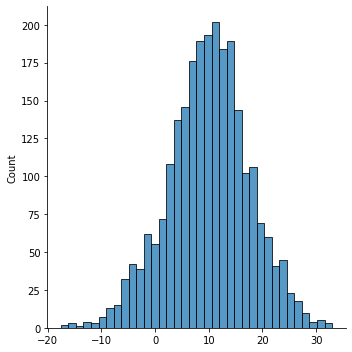

In [215]:
sns.displot(cadg.sum())

In [237]:
manmep=mepscoreg.sum().to_frame().reset_index()
manmep.rename({'index' : 'id', 0:'MEP1Bmanual'}, axis='columns', inplace=True)

In [240]:
mancad=cadg.sum().to_frame().reset_index()
mancad.rename({'index' : 'id', 0:'CADmanual'}, axis='columns', inplace=True)

In [220]:
msc['id']=msc.FID+"_"+msc.IID

In [221]:
csc['id']=csc.FID+"_"+csc.IID

In [224]:
msc.drop(['FID', 'IID', 'PHENO', 'CNT', 'CNT2'], axis='columns', inplace=True)
csc.drop(['FID', 'IID', 'PHENO', 'CNT', 'CNT2'], axis='columns', inplace=True)

In [541]:
allsc=msc.merge(csc, on='id', how='outer')

In [542]:
allsc.rename({'SCORE_x':"MEP1B", "SCORE_y":"CAD"}, axis='columns', inplace=True)

In [543]:
allsc=allsc.merge(manmep, on="id", how='outer')
allsc=allsc.merge(mancad, on="id", how='outer')

In [544]:
allsc.iloc[:,[j for j, c in enumerate(allsc.columns) if j != 1]]=allsc.iloc[:,[j for j, c in enumerate(allsc.columns) if j != 1]].apply(lambda x: (x-x.mean())/x.std(), axis=0)

In [545]:
allsc.drop('id', axis='columns').corr()

,MEP1B,CAD,MEP1Bmanual,CADmanual
MEP1B,1.000000,-0.019078,1.000000,-0.019035
CAD,-0.019078,1.000000,-0.019078,0.999994
MEP1Bmanual,1.000000,-0.019078,1.000000,-0.019035
CADmanual,-0.019035,0.999994,-0.019035,1.000000


In [268]:
allsc[allsc.CAD!=allsc.CADmanual]

,MEP1B,id,CAD,MEP1Bmanual,CADmanual
0,-0.416302,HG00096_HG00096,-0.617001,-0.416303,-0.611745
1,-0.958203,HG00097_HG00097,-0.552885,-0.958203,-0.554222
2,-0.590982,HG00099_HG00099,-0.100988,-0.590982,-0.100965
3,0.978672,HG00100_HG00100,-0.269309,0.978672,-0.268639
4,-1.171186,HG00101_HG00101,-0.055126,-1.171186,-0.053979
...,...,...,...,...,...
2499,-0.260715,NA21137_NA21137,-1.271608,-0.260715,-1.271979
2500,1.495205,NA21141_NA21141,1.144704,1.495210,1.148143
2501,1.236942,NA21142_NA21142,0.194592,1.236941,0.200000
2502,-1.277836,NA21143_NA21143,-0.855316,-1.277833,-0.852606


In [292]:
cadw=allsc.loc[:,['id','CAD']]
cadw[['FID', 'IID']]=cadw['id'].str.split('_', expand=True)
cadw=cadw.drop('id',axis=1)
cadw.iloc[:,[1,2,0]].to_csv("/lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/CAD.pheno", sep="\t", index=False)

## Performing association 

Creating an assoc set:

```bash
for i in {1..22}; do plink2 --vcf /lustre/groups/itg/shared/referenceData/1kG/20190425_NYGC_GATK/CCDG_13607_B01_GRM_WGS_2019-02-19_chr$i.recalibrated_variants.vcf.gz --maf 0.005 --make-pgen --out chr$i.autosomal & done
for i in {2..22}; do echo chr$i.autosomal >> auto.tomerge;done
plink2 --pfile chr1.autosomal --pmerge-list auto.tomerge --max-alleles 2 --make-bed --out autosomal.maf0.005
cut -f1,2 autosomal.maf0.005.fam|sort -R | head -1000 > thin
plink2 --bfile autosomal.maf0.005 --keep thin --make-bed --out autosomal.maf0.005.thin
awk '$2="chr"$1":"$4' autosomal.maf0.005.thin.bim | sponge autosomal.maf0.005.thin.bim
sort -R autosomal.maf0.005.thin.bim | head -100000 | sort -k1,1n -k4,4n | cut -f2 -d' ' > additional.100k.var
plink2 --bfile autosomal.maf0.005.thin --extract additional.100k.var --make-bed --out autosomal.maf0.005.thin.100k
awk '{print $2,$2}' thin > thin.2id
plink --bfile autosomal.forPRS --keep thin.2id --make-bed --out autosomal.forPRS.1k
plink --bfile autosomal.maf0.005.thin.100k --bmerge autosomal.forPRS.1k --make-bed --out PRS.course.testset
```

### CAD score, no covar

In [293]:
!wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20210606.zip && unzip plink_linux_x86_64_20210606.zip && rm plink_linux_x86_64_20210606.zip && rm prettify toy.* LICENSE

--2021-11-15 05:56:05--  https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20210606.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.92.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.92.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8917076 (8.5M) [application/zip]
Saving to: 'plink_linux_x86_64_20210606.zip'

plink_linux_x86_64_ 100%[===================>]   8.50M  8.41MB/s    in 1.0s    

2021-11-15 05:56:06 (8.41 MB/s) - 'plink_linux_x86_64_20210606.zip' saved [8917076/8917076]

Archive:  plink_linux_x86_64_20210606.zip
replace plink? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [356]:
!./plink --bfile /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PRS.course.testset --pheno /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/CAD.pheno --allow-no-sex --assoc --out CAD

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CAD.log.
Options in effect:
  --allow-no-sex
  --assoc
  --bfile /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PRS.course.testset
  --out CAD
  --pheno /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/CAD.pheno

3095754 MB RAM detected; reserving 1547877 MB for main workspace.
175219 variants loaded from .bim file.
1000 people (0 males, 0 females, 1000 ambiguous) loaded from .fam.
Ambiguous sex IDs written to CAD.nosex .
1000 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1000 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done

In [357]:
cada=pd.read_table("CAD.qassoc", delim_whitespace=True)

In [358]:
cada

,CHR,SNP,BP,NMISS,BETA,SE,R2,T,P
0,1,chr1:10616,10616,705,0.06842,0.11210,0.000530,0.6106,0.541600
1,1,chr1:18717,18717,787,0.46020,0.31870,0.002650,1.4440,0.149100
2,1,chr1:107125,107125,993,-0.08869,0.12290,0.000525,-0.7216,0.470700
3,1,chr1:126847,126847,1000,-0.19570,0.09197,0.004515,-2.1270,0.033630
4,1,chr1:201322,201322,824,0.07386,0.20950,0.000151,0.3526,0.724500
...,...,...,...,...,...,...,...,...,...
175214,22,chr22:50713346,50713346,1000,0.22510,0.06354,0.012420,3.5420,0.000415
175215,22,chr22:50747663,50747663,1000,0.19000,0.12110,0.002459,1.5690,0.117100
175216,22,chr22:50764687,50764687,1000,0.12330,0.10160,0.001474,1.2140,0.225200
175217,22,chr22:50773902,50773902,1000,-0.14710,0.08963,0.002691,-1.6410,0.101100


In [359]:
!pip install qmplot

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


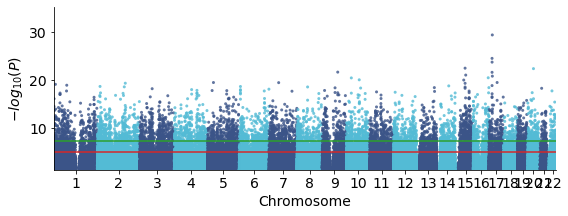

<AxesSubplot:xlabel='Chromosome', ylabel='$-log_{10}{(P)}$'>

In [360]:
from qmplot import manhattanplot
cada.dropna(how="any", inplace=True, axis=0)
manhattanplot(cada, chrom="CHR", pos="BP")

#### CAD score, we add covariates:


the below takes too long, use plink2:
```bash
plink2 --glm --pheno CAD.pheno --bfile autosomal.maf0.005.thin --covar PCs.eigenvec  --out test --allow-no-sex
```

In [361]:
!./plink --pheno /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/CAD.pheno --bfile /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PRS.course.testset --linear hide-covar --covar /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PCs.eigenvec --out CAD.wPC --allow-no-sex

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CAD.wPC.log.
Options in effect:
  --allow-no-sex
  --bfile /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PRS.course.testset
  --covar /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PCs.eigenvec
  --linear hide-covar
  --out CAD.wPC
  --pheno /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/CAD.pheno

3095754 MB RAM detected; reserving 1547877 MB for main workspace.
175219 variants loaded from .bim file.
1000 people (0 males, 0 females, 1000 ambiguous) loaded from .fam.
Ambiguous sex IDs written to CAD.wPC.nosex .
1000 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
--covar: 10 covariates loaded.
Before main variant filters, 1000 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334

In [362]:
cada=pd.read_table("CAD.wPC.assoc.linear", delim_whitespace=True)

In [363]:
cada

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P
0,1,chr1:10616,10616,C,ADD,705,0.14000,1.3750,0.1695
1,1,chr1:18717,18717,G,ADD,787,0.29840,1.0100,0.3129
2,1,chr1:107125,107125,G,ADD,993,-0.06048,-0.5416,0.5882
3,1,chr1:126847,126847,C,ADD,1000,0.08430,0.9673,0.3336
4,1,chr1:201322,201322,G,ADD,824,-0.09441,-0.4917,0.6231
...,...,...,...,...,...,...,...,...,...
175214,22,chr22:50713346,50713346,G,ADD,1000,0.02904,0.3665,0.7141
175215,22,chr22:50747663,50747663,C,ADD,1000,-0.03701,-0.3130,0.7544
175216,22,chr22:50764687,50764687,T,ADD,1000,-0.09067,-0.9587,0.3379
175217,22,chr22:50773902,50773902,AT,ADD,1000,-0.07175,-0.8647,0.3874


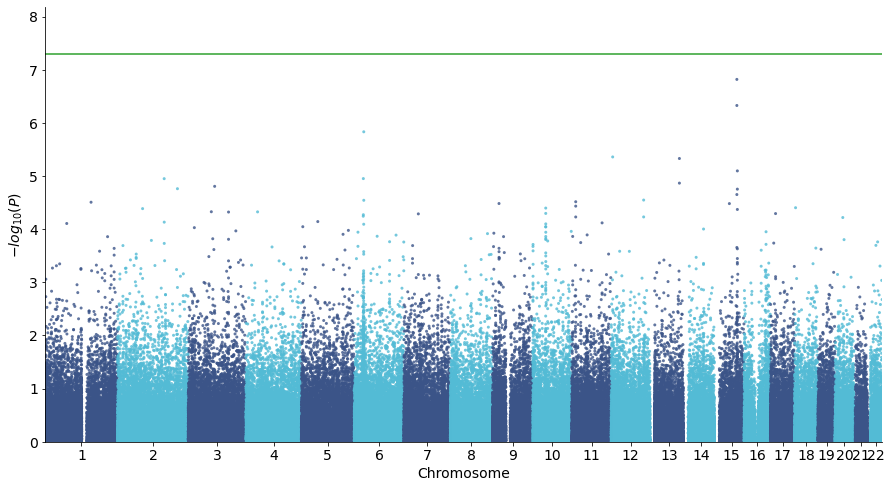

In [390]:
from qmplot import manhattanplot
cada.dropna(how="any", inplace=True, axis=0)
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 8))
m=manhattanplot(cada, chrom="CHR", pos="BP", suggestiveline=None, ax=ax)

In [320]:
mepw=allsc.loc[:,['id','MEP1B']]
mepw[['FID', 'IID']]=mepw['id'].str.split('_', expand=True)
mepw=mepw.drop('id',axis=1)
mepw.iloc[:,[1,2,0]].to_csv("/lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/MEP1B.pheno", sep="\t", index=False)

In [392]:
!./plink --pheno /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/MEP1B.pheno --bfile /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PRS.course.testset --linear hide-covar --covar /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PCs.eigenvec --out MEP1B.wPC --allow-no-sex

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to MEP1B.wPC.log.
Options in effect:
  --allow-no-sex
  --bfile /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PRS.course.testset
  --covar /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PCs.eigenvec
  --linear hide-covar
  --out MEP1B.wPC
  --pheno /lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/MEP1B.pheno

3095754 MB RAM detected; reserving 1547877 MB for main workspace.
175219 variants loaded from .bim file.
1000 people (0 males, 0 females, 1000 ambiguous) loaded from .fam.
Ambiguous sex IDs written to MEP1B.wPC.nosex .
1000 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
--covar: 10 covariates loaded.
Before main variant filters, 1000 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930

In [393]:
mepa=pd.read_table("MEP1B.wPC.assoc.linear", delim_whitespace=True)

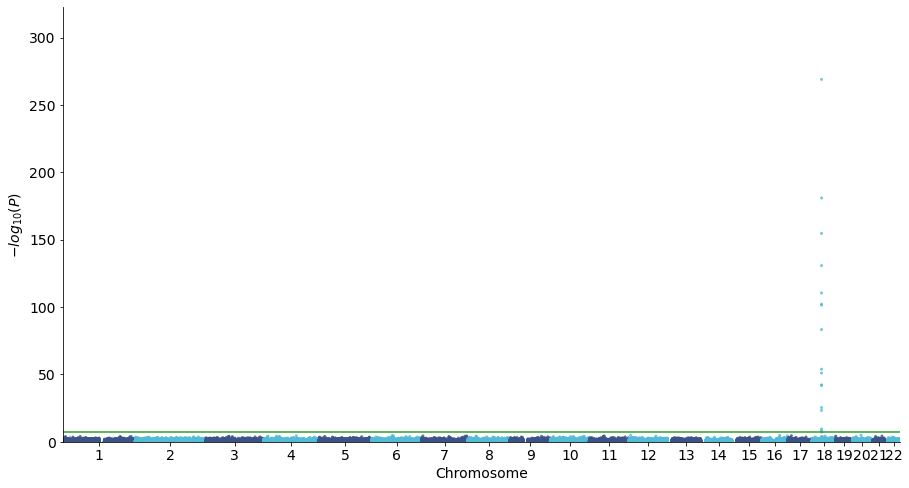

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


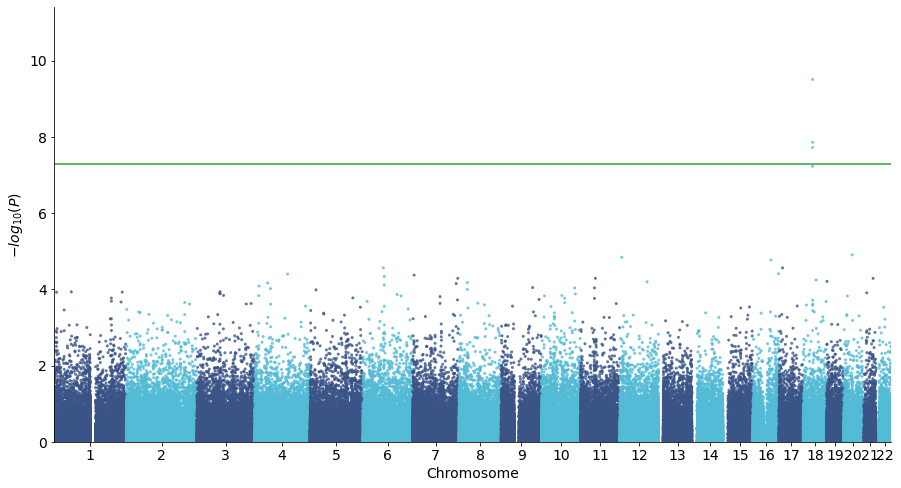

<AxesSubplot:xlabel='Chromosome', ylabel='$-log_{10}{(P)}$'>

In [405]:
import numpy as np
import matplotlib.pyplot as plt
mepa['logp']=-1*np.log10(mepa.P)
mepa.replace([np.inf, -np.inf], np.nan, inplace=True)
mepa.dropna(how="any", inplace=True, axis=0)
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 8))
m=manhattanplot(mepa, chrom="CHR", pos="BP", suggestiveline=None, ax=ax)
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 8))
manhattanplot(mepa[mepa.logp<10], chrom="CHR", pos="BP", suggestiveline=None, ax=ax)
#qqplot(mepa.P, uniform, fit=True, line='45')
#plt.show()

## Generating fake phenotypes for correlations

### MEP1B

This is the easiest. We use the predicted scores and add a Gaussian error.

In [533]:
thousand=pd.read_table("/lustre/groups/itg/teams/analytics/teaching/Gagneur_PRS/PRS.course.testset.fam", delim_whitespace=True, header=None)

0      HG00100_HG00100
1      HG00101_HG00101
2      HG00107_HG00107
3      HG00110_HG00110
4      HG00113_HG00113
            ...       
995    NA21124_NA21124
996    NA21127_NA21127
997    NA21129_NA21129
998    NA21133_NA21133
999    NA21141_NA21141
Name: 1, Length: 1000, dtype: object

In [548]:
allsc=allsc[allsc.id.isin(thousand.loc[:,1]+"_"+thousand.loc[:,1])]

In [549]:
allsc

,MEP1B,id,CAD,MEP1Bmanual,CADmanual
3,0.978672,HG00100_HG00100,-0.269309,0.978672,-0.268639
4,-1.171186,HG00101_HG00101,-0.055126,-1.171186,-0.053979
9,-0.554983,HG00107_HG00107,-1.149339,-0.554983,-1.151884
12,-1.794373,HG00110_HG00110,0.588146,-1.794370,0.581087
15,0.162431,HG00113_HG00113,-0.609841,0.162430,-0.613248
...,...,...,...,...,...
2490,-0.994201,NA21124_NA21124,0.157557,-0.994202,0.159120
2493,1.789484,NA21127_NA21127,2.249775,1.789478,2.253687
2495,-0.793327,NA21129_NA21129,-1.452013,-0.793328,-1.452341
2497,-0.968840,NA21133_NA21133,-0.537862,-0.968840,-0.540104


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='MEP1B', ylabel='noisyMEP'>

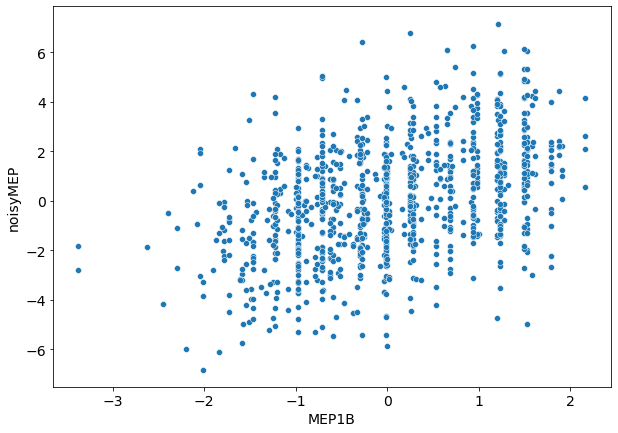

In [550]:
import numpy as np

allsc['noisyMEP'] = allsc.MEP1B + np.random.normal(0,2,len(allsc.index))
sns.scatterplot(allsc.MEP1B, allsc.noisyMEP)

In [551]:
allsc.loc[:,["MEP1B", 'noisyMEP']].corr()

,MEP1B,noisyMEP
MEP1B,1.000000,0.427365
noisyMEP,0.427365,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='CAD', ylabel='CAD'>

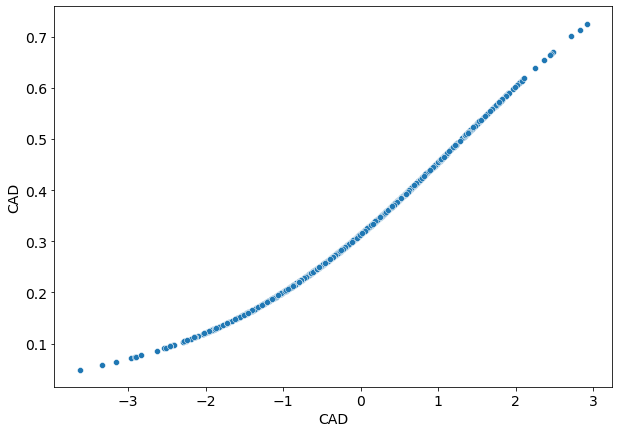

In [582]:
prev=0.5
k=0.6
x0=np.log2(np.exp(np.log2(1)-np.log2(prev))-1)/k
#x0=(np.log2(np.exp(np.log2(1)-np.log2(0.1))-1))/k
pvector=1/(1+np.exp(-k*(allsc.CAD-x0)))
sns.scatterplot(allsc.CAD, pvector)

In [583]:
pd.Series(pvector.apply(lambda x : np.random.binomial(n=1, p=x))).value_counts()

0    705
1    295
Name: CAD, dtype: int64

<AxesSubplot:xlabel='CAD', ylabel='Count'>

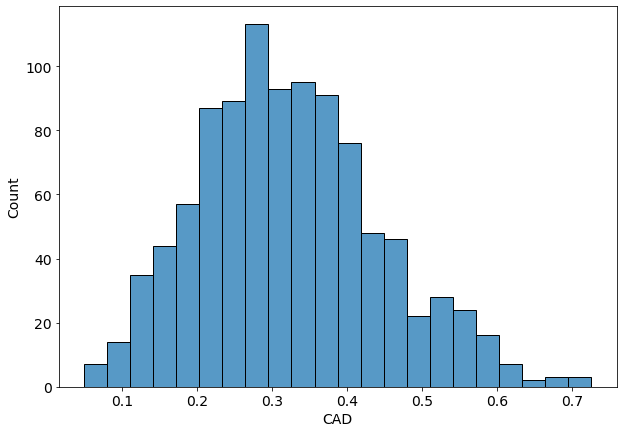

In [584]:
sns.histplot(pvector)

In [585]:
allsc['simCAD']=pvector.apply(lambda x : np.random.binomial(n=1, p=x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [586]:
allsc.CAD.quantile([0.1, 0.9])

0.1   -1.301830
0.9    1.203025
Name: CAD, dtype: float64

In [587]:
allsc.simCAD[allsc.CAD<allsc.CAD.quantile(0.1)].value_counts()

0    85
1    15
Name: simCAD, dtype: int64

In [589]:
allsc.simCAD[allsc.CAD>allsc.CAD.quantile(0.9)].value_counts()

1    54
0    46
Name: simCAD, dtype: int64

In [590]:
(15/85)/(54/46)

0.1503267973856209

In [594]:
allsc.loc[:,['id', 'simCAD']].to_csv("CAD.phenotype", index=False, header=None, sep="\t")

In [595]:
!head CAD.phenotype

HG00100_HG00100	0
HG00101_HG00101	0
HG00107_HG00107	0
HG00110_HG00110	0
HG00113_HG00113	1
HG00114_HG00114	0
HG00117_HG00117	0
HG00118_HG00118	1
HG00119_HG00119	1
HG00120_HG00120	1


In [597]:
allsc.loc[:,['id', 'noisyMEP']].to_csv("MEP1B.phenotype", index=False, header=None, sep="\t")

In [598]:
!pwd

/lustre/groups/itg/shared/notebooks/arthur.gilly/teaching
